In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm
import numpy as np
import seaborn as sns
import plotly.express as px
import pickle
import emoji
from bertopic import BERTopic
import hdbscan

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.metrics import pairwise_distances

from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer

In [ ]:
# Load the data
data = pickle.load(open('/content/data_preprocessed_classification.pkl', 'rb'))

# Convert to DataFrame
data = pd.DataFrame(data)

data = data[['meals']]
data = data[data['meals'].apply(lambda x: len(x) > 0)]
data['meals'] = data['meals'].apply(lambda meals: [meal.lower() for meal in meals])
data.reset_index(drop=True, inplace=True)
dish_mapping = {
    "biriyani": "biryani",
    "biryanis": "biryani",
    "veggie": "veg",
    "veggies": "veg",
    "non veg": "non-veg",
    "pizzas": "pizza",
    "burgers": "burger",
    "cakes":"cake",
    "beers": "beer",
    "soups":"soup",
    "kebabs":"kebab",
    "fries":"french fries",
    "shakes":"shake",
    "parathas":"paratha",
    "curries":"curry",
    "ice creams":"ice cream",
    "icecream":"ice cream",
    "babycorn":"baby corn",
    "brownies": "brownie",
    "chicken biryani": "biryani"


}
data['meals'] = data['meals'].apply(lambda meals: [dish_mapping.get(dish, dish) for dish in meals])
all_words = [dish for meal_list in data['meals'] for dish in meal_list]

delete_list = [
    # Ingredients and non-dishes
    "chicken", "veg", "fish", "paneer", "coffee", "cheese", "spices",
    "gravy", "chocolate", "wings", "vegetables",
    "garlic", "onion", "meat", "egg", "oil", "salt", "water", "beer", "mocktails",
    "non-veg", "sauce", "cocktails", "rice", "corn", "potato", "fruits", "naan",
    "noodles", "cake", "ice cream", "soup", "starters", "pastries", "shake",
    "donuts", "bread", "masala", "sauces", "salad", "pork", "butter", "chicken pieces",
    "onions", "mushroom", "tea", "breads", "cupcakes", "salads", "waffles", "cream",
    "sandwich", "mayo", "mutton", "mint", "lamb", "broccoli", "coconut", "coconut milk"
    "mojito", "mango", "mocktail", "baby corn", "pepper", "cucumber", "potatoes",
    "mayonnaise", "lemon", "tomato", "cocktail", "herbs", "capsicum", "carrot", "coriander",
    "strawberry", "orange", "sandwiches", "dessert", "desserts", "pineapple", "mushrooms",
    "sweets", "spinach"


]
data['meals'] = data['meals'].apply(
    lambda meals: [dish for dish in meals if dish not in delete_list]
)
data.head()

,meals
0,[penne alfredo pasta]
1,"[kodi drumsticks, basket mutton biryani]"
2,"[tawa fish, basket biryani, biryani]"
3,[chili honey lotus stem]
4,[honey chilli lotus]


In [ ]:
# Remove emojis that were kept in dishes df
data['meals'] = data['meals'].apply(lambda meals: [emoji.replace_emoji(meal, replace='') for meal in meals])

data.head()

In [ ]:
def cooccurrence_matrix_meals_generator(meals):

    co_occurrences = defaultdict(Counter)

    for meal_list in tqdm(meals):
        for dish1 in meal_list:
            for dish2 in meal_list:
                if dish1 != dish2:
                    co_occurrences[dish1][dish2] += 1


    unique_dishes = list(set(dish for meal_list in meals for dish in meal_list))


    co_matrix = np.zeros((len(unique_dishes), len(unique_dishes)), dtype=int)


    dish_index = {dish: idx for idx, dish in enumerate(unique_dishes)}
    for dish, neighbors in co_occurrences.items():
        for neighbor, count in neighbors.items():
            co_matrix[dish_index[dish]][dish_index[neighbor]] = count


    co_matrix_df = pd.DataFrame(co_matrix, index=unique_dishes, columns=unique_dishes)


    #sorted_indices = co_matrix_df.sum(axis=1).sort_values(ascending=False).index
    #co_matrix_df = co_matrix_df.loc[sorted_indices, sorted_indices]
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=1)
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=0)
    return co_matrix_df

# Generate the co-occurrence matrix
meals_co_occurrence = cooccurrence_matrix_meals_generator(data['meals'].tolist())

100%|██████████| 5904/5904 [00:00<00:00, 86895.03it/s]


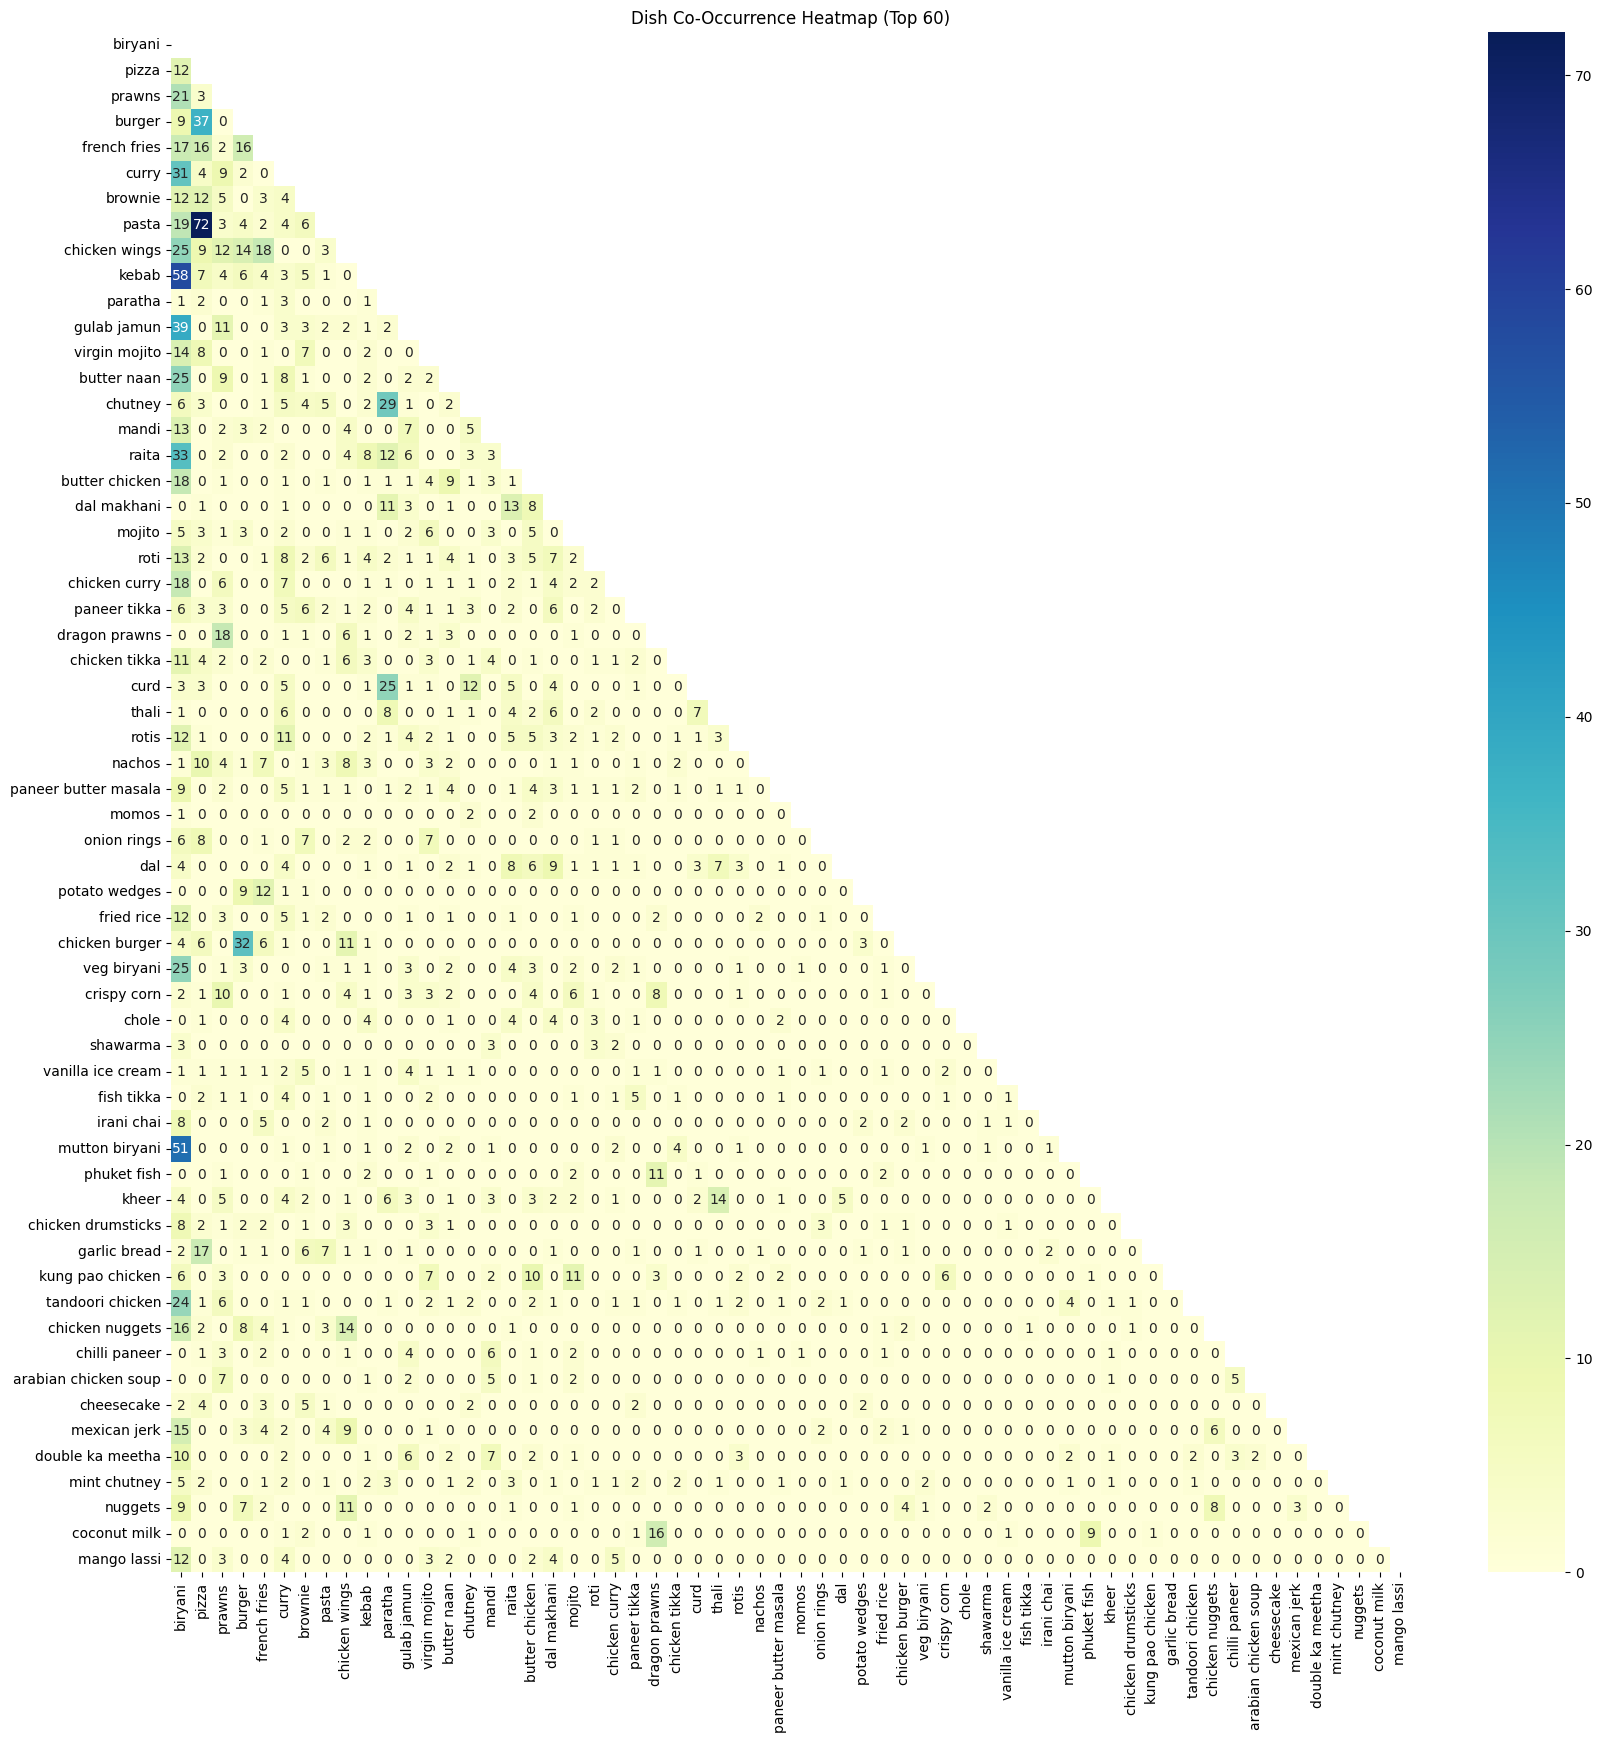

In [ ]:
mask = np.triu(np.ones_like(meals_co_occurrence.iloc[:60, :60], dtype=bool))


plt.figure(figsize=(20, 20))
sns.heatmap(meals_co_occurrence.iloc[:60, :60], cmap="YlGnBu", mask=mask, annot=True, fmt="d")
plt.title("Dish Co-Occurrence Heatmap (Top 60)")
plt.show()

In [ ]:
fig = px.imshow(meals_co_occurrence.iloc[:60, :60], color_continuous_scale='YlGnBu',
                labels=dict(x="Dish", y="Dish", color="Count"),
                title="Dish Co-occurrence (60 most frequent co-occurring words)",
                width=1200, height=1200)

fig.show()

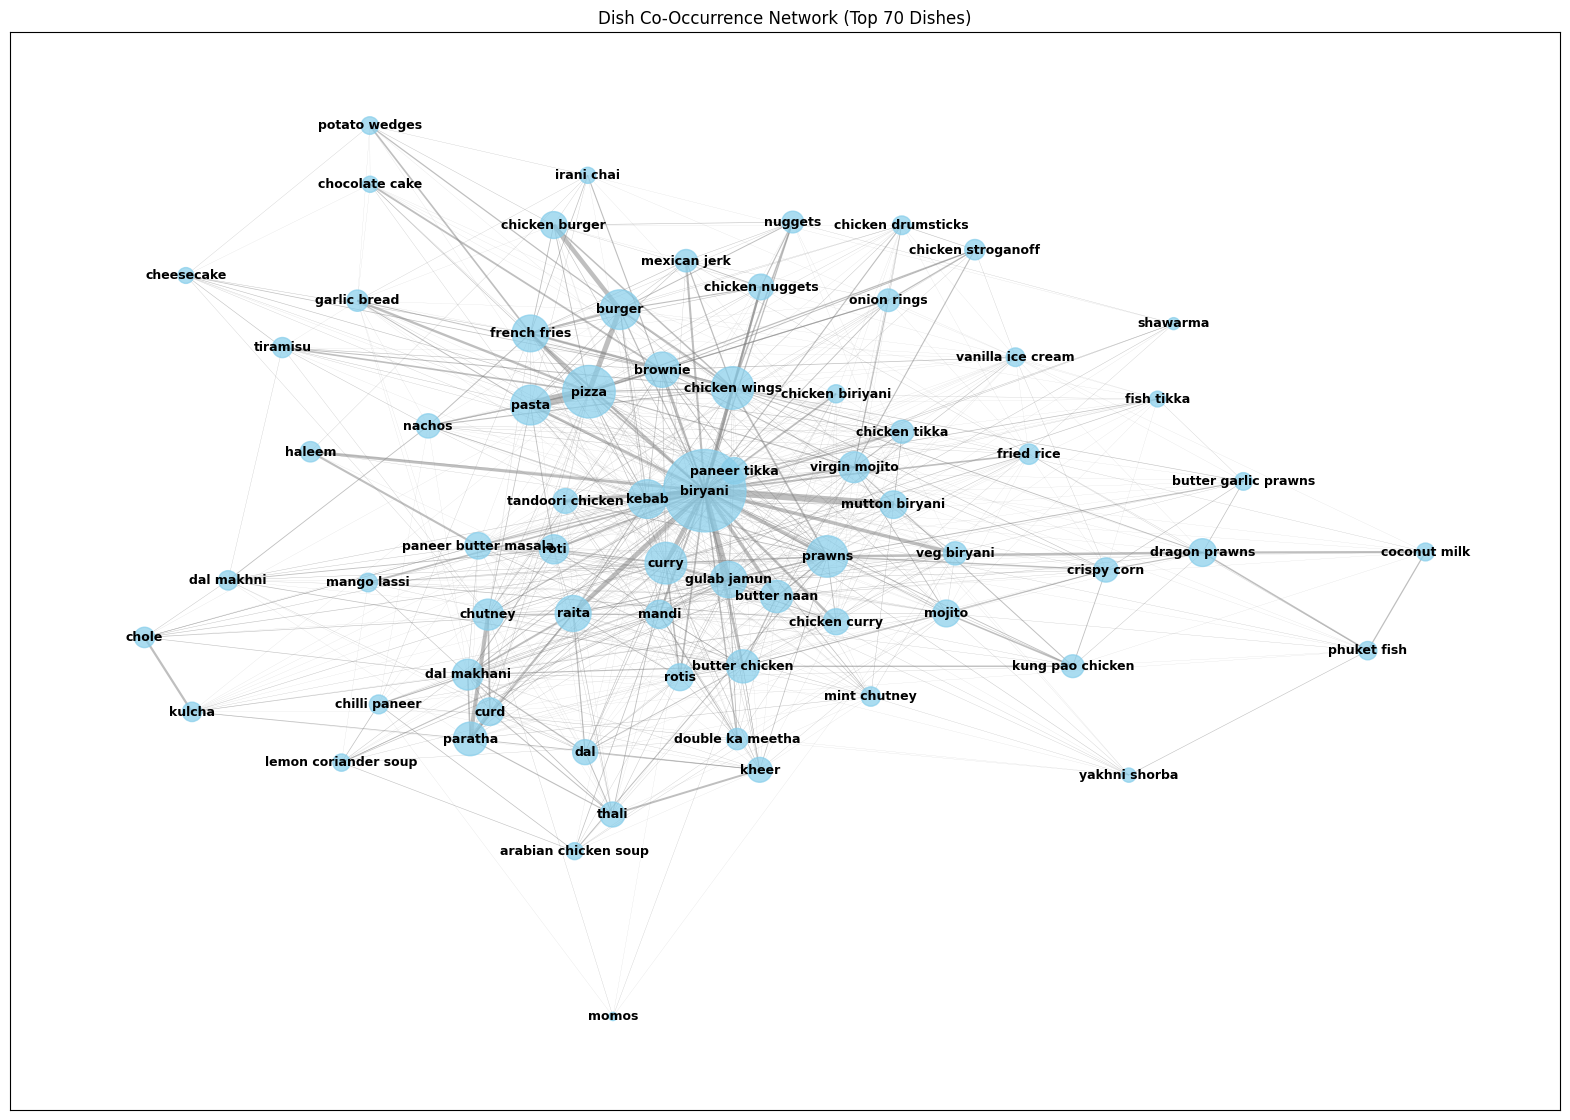

In [ ]:
def cooccurrence_network_generator(cooccurrence_matrix_df, n_highest_dishes, output=None):

    filtered_df = cooccurrence_matrix_df.iloc[:n_highest_dishes, :n_highest_dishes]
    graph = nx.Graph()


    for dish in filtered_df.columns:
        graph.add_node(dish, size=filtered_df[dish].sum())


    for dish1 in filtered_df.columns:
        for dish2 in filtered_df.columns:
            if dish1 != dish2 and filtered_df.loc[dish1, dish2] > 0:
                graph.add_edge(dish1, dish2, weight=filtered_df.loc[dish1, dish2])



    pos = nx.spring_layout(graph, k=0.5)


    edge_weights = [0.1 * graph[u][v]['weight'] for u, v in graph.edges()]


    node_sizes = [data['size'] * 5 for _, data in graph.nodes(data=True)]

    # Create the network graph
    plt.figure(figsize=(20, 14))
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', width=edge_weights, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=9, font_weight='bold')

    plt.title(f"Dish Co-Occurrence Network (Top {n_highest_dishes} Dishes)")
    plt.show()


# Example usage with your co-occurrence matrix
cooccurrence_network_generator(meals_co_occurrence, 70)

# Clustering using HDBScan with precalculated distance matrices based on co-occurence

In [ ]:
normalized_matrix = normalize(meals_co_occurrence, norm='l2', axis=1)

distance_matrix_cosine = cosine_distances(normalized_matrix)
distance_matrix_euclidean = euclidean_distances(normalized_matrix)
distance_matrix_pairwise = pairwise_distances(normalized_matrix, metric='jaccard')

In [ ]:
# Perform clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=30, min_samples=30)

clusters_cosine = clusterer.fit_predict(distance_matrix_cosine)
clusters_euclidean = clusterer.fit_predict(distance_matrix_euclidean)
clusters_pairwise = clusterer.fit_predict(distance_matrix_pairwise)

# Calculate silhouette scores for each clustering
silhouette_scores = {
    'cosine': silhouette_score(distance_matrix_cosine, clusters_cosine, metric='precomputed'),
    'euclidean': silhouette_score(distance_matrix_euclidean, clusters_euclidean, metric='precomputed'),
    'pairwise': silhouette_score(distance_matrix_pairwise, clusters_pairwise, metric='precomputed')
}

# Print silhouette scores
for metric, score in silhouette_scores.items():
    print(f"Silhouette Score for {metric} clustering: {score}")

Silhouette Score for cosine clustering: -0.04023297791762982
Silhouette Score for euclidean clustering: -0.16922655110939028
Silhouette Score for pairwise clustering: 0.05926424758773457


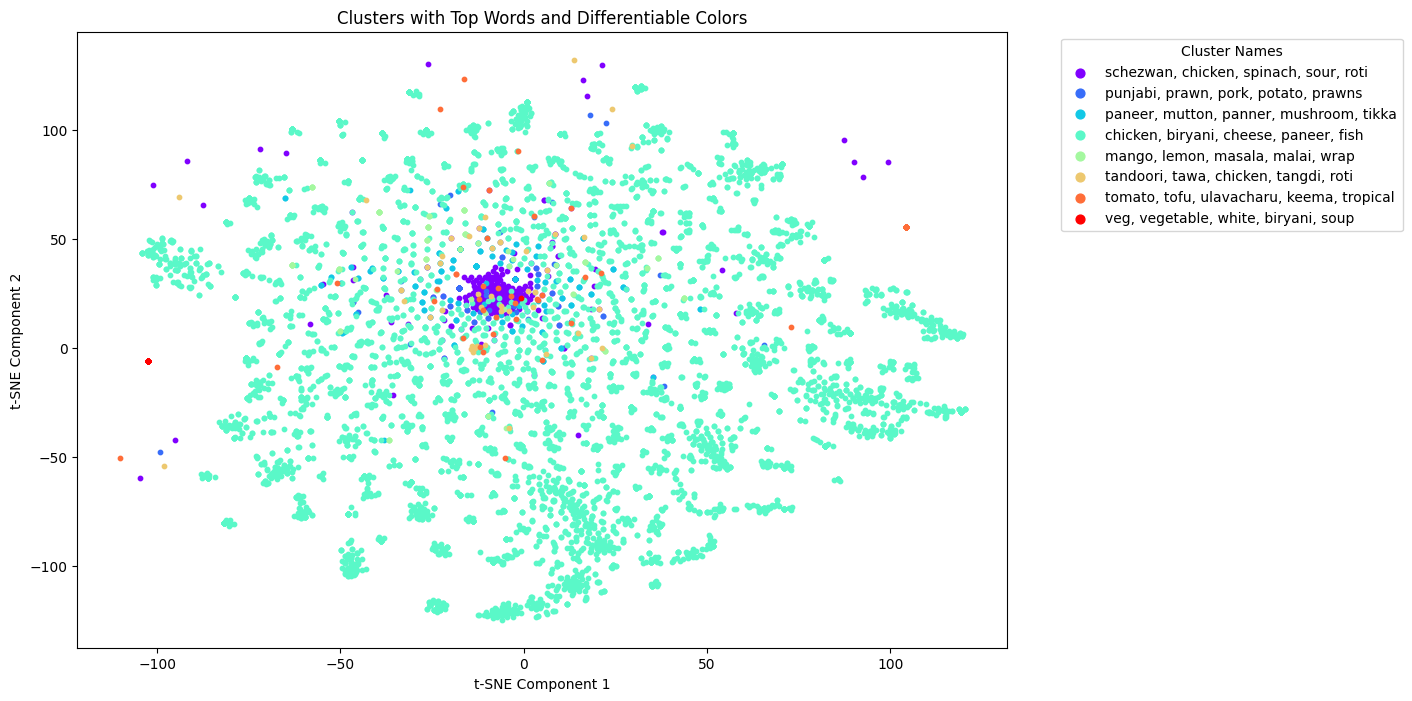

Cluster Names Based on Top Words:
Cluster 0: schezwan, chicken, spinach, sour, roti
Cluster 1: punjabi, prawn, pork, potato, prawns
Cluster 2: paneer, mutton, panner, mushroom, tikka
Cluster 3: chicken, biryani, cheese, paneer, fish
Cluster 4: mango, lemon, masala, malai, wrap
Cluster 5: tandoori, tawa, chicken, tangdi, roti
Cluster 6: tomato, tofu, ulavacharu, keema, tropical
Cluster 7: veg, vegetable, white, biryani, soup


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Simulated text data for each point (Replace this with your real text data)
data_text = np.unique(list(meals_co_occurrence.columns))

# Fit the HDBSCAN model
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=50, min_samples=30)
clusterer.fit(distance_matrix_pairwise)

# Filter out noise points
non_noise_indices = clusterer.labels_ != -1
filtered_labels = clusterer.labels_[non_noise_indices]
filtered_texts = np.array(data_text)[non_noise_indices]

# Extract top words per cluster
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(filtered_texts)
feature_names = vectorizer.get_feature_names_out()

cluster_top_words = {}
for label in np.unique(filtered_labels):
    cluster_indices = np.where(filtered_labels == label)[0]
    cluster_tfidf = X_tfidf[cluster_indices].sum(axis=0).A1  # Convert sparse matrix to 1D array
    top_word_indices = np.argsort(cluster_tfidf)[::-1][:5]  # Indices of top words
    top_words = [str(feature_names[i]) for i in top_word_indices]  # Ensure words are strings
    cluster_top_words[label] = top_words

# Assign cluster names based on top words
cluster_names = {label: ", ".join(words) for label, words in cluster_top_words.items()}

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_data = tsne.fit_transform(distance_matrix_euclidean[non_noise_indices][:, non_noise_indices])

# Use a highly differentiable color map (e.g., 'tab10' or 'hsv')
unique_labels = np.unique(filtered_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))  # Adjusted for differentiability
label_to_color = dict(zip(unique_labels, colors))

# Plot with updated color scheme and cluster names
plt.figure(figsize=(12, 8))
for label in unique_labels:
    cluster_points = reduced_data[filtered_labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                color=label_to_color[label], label=f"{cluster_names[label]}", s=10)

plt.title("Clusters with Top Words and Differentiable Colors")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster Names")
plt.show()

# Print cluster names for reference
print("Cluster Names Based on Top Words:")
for label, words in cluster_names.items():
    print(f"Cluster {label}: {words}")


In [ ]:
# Organize words into their respective clusters
cluster_dict = {}
for word, cluster in zip(meals_co_occurrence.columns, clusters_euclidean):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = []
    cluster_dict[cluster].append(word)

# Print the clusters and their words
for cluster_id, cluster_words in cluster_dict.items():
    if cluster_id == -1:
        print(f"Cluster {cluster_id} (Noise/Outliers):")
    else:
        print(f"Cluster {cluster_id}:")
    print(", ".join(cluster_words))
    print("-" * 40)


Cluster -1 (Noise/Outliers):
biryani, pizza, burger, french fries, curry, brownie, chicken wings, paratha, virgin mojito, mandi, butter chicken, dal makhani, mojito, roti, chicken curry, paneer tikka, dragon prawns, chicken tikka, thali, rotis, nachos, paneer butter masala, momos, onion rings, dal, potato wedges, fried rice, crispy corn, chole, shawarma, vanilla ice cream, fish tikka, irani chai, phuket fish, kheer, chicken drumsticks, kung pao chicken, garlic bread, chicken nuggets, chilli paneer, arabian chicken soup, cheesecake, mexican jerk, double ka meetha, mint chutney, nuggets, coconut milk, chicken stroganoff, yakhni shorba, tiramisu, lemon coriander soup, haleem, chocolate cake, dal makhni, butter garlic prawns, sushi, cinnamon, pomfret, bruschetta, lemonade, chicken mandi, omelette, chole bhature, caramel, tomatoes, dragon chicken, sugar, manchow soup, ginger, cardamom, gin, tandoor, basmati rice, prawn, tikka, pork ribs, spice, tiger prawns, chicken soup, black pepper, panc

# BERTopic Clustering using pretrained embeddings




In [ ]:
documents = list(meals_co_occurrence.columns)

# Parameter grid for HDBSCAN
min_cluster_sizes = [5, 10, 20, 30]
min_samples_list = [1, 5, 10]

best_score = -1
best_model = None
best_params = {}

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        # Initialize a custom HDBSCAN model with the current parameters
        custom_hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                         min_samples=min_samples)

        # Initialize BERTopic with the custom HDBSCAN model
        topic_model = BERTopic(hdbscan_model=custom_hdbscan)

        # Fit and transform the documents
        topics, probs = topic_model.fit_transform(documents)

        embeddings = topic_model._extract_embeddings(documents)

        # Convert topics to a NumPy array
        labels = np.array(topics)

        # Exclude noise points with cluster label -1
        mask = labels != -1
        if mask.sum() > 1:  # Ensure there's more than one data point after filtering out noise
            score = silhouette_score(embeddings[mask], labels[mask])

            # Check if this is the best silhouette score so far
            if score > best_score:
                best_score = score
                best_model = topic_model
                best_params = {
                    "min_cluster_size": min_cluster_size,
                    "min_samples": min_samples
                }

print("Best HDBSCAN Parameters:", best_params)
print("Best Silhouette Score:", best_score)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Best HDBSCAN Parameters: {'min_cluster_size': 5, 'min_samples': 5}
Best Silhouette Score: 0.10840251


In [ ]:
documents = list(meals_co_occurrence.columns)

best_params = {'min_cluster_size': 5, 'min_samples': 5}

custom_hdbscan = hdbscan.HDBSCAN(**best_params)
topic_model = BERTopic(hdbscan_model=custom_hdbscan)

# Fit and transform the documents
topics, probs = topic_model.fit_transform(documents)


topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1473,-1_cocktail_cherry_guava_pasta,"[cocktail, cherry, guava, pasta, cajun, masala...","[mamsam vepudu, fish masala, chicken dry red c..."
1,0,113,0_paneer_shahi_kadhai_patiala,"[paneer, shahi, kadhai, patiala, palak, wala, ...","[chicken n paneer, paneer m, paneer ]"
2,1,84,1_burger_burgers_patty_zinger,"[burger, burgers, patty, zinger, milky, cosmic...","[chicken burger, burger 🍔, burger]"
3,2,74,2_noodles_hakka_noodle_soft,"[noodles, hakka, noodle, soft, soba, pan, udon...","[veg noodles, chicken noodles, veg noodles veg..."
4,3,66,3_cake_cakes_cup_cupcakes,"[cake, cakes, cup, cupcakes, carrot, lava, spo...","[cheese cake, chocolate cup cakes, chocolate c..."
...,...,...,...,...,...
340,339,5,339_methi_warki_malai_matar,"[methi, warki, malai, matar, roti, paratha, , ...","[methi roti, methi malai paratha, malai methi ..."
341,340,5,340_meats_beef_noddles_soba,"[meats, beef, noddles, soba, peices, meat, red...","[beef soba noddles, meats, red meats]"
342,341,5,341_uts_ters_ings_ers,"[uts, ters, ings, ers, daserts, , , , , ]","[ers, ings, daserts]"
343,342,5,342_chinese_choppsuey_chinesee_cuisine,"[chinese, choppsuey, chinesee, cuisine, choups...","[chicken chinese choppsuey, chinese, chinese a..."


In [ ]:
cuisine_labels =  ['American', 'Andhra', 'Arabian', 'Asian', 'BBQ', 'Bakery',
       'Beverages', 'Biryani', 'Burger', 'Cafe', 'Chinese', 'Continental',
       'Desserts', 'European', 'Fast Food', 'Finger Food', 'Goan',
       'Healthy Food', 'Hyderabadi', 'Ice Cream', 'Indonesian', 'Italian',
       'Japanese', 'Juices', 'Kebab', 'Lebanese', 'Mediterranean',
       'Mexican', 'Modern Indian', 'Momos', 'Mughlai', 'North Eastern',
       'North Indian', 'Pizza', 'Salad', 'Seafood', 'South Indian',
       'Spanish', 'Street Food', 'Sushi', 'Thai', 'Wraps']

# Extract top words for each topic
all_topics = topic_model.get_topic_info()
topic_ids = all_topics.Topic.unique().tolist()

# Embed both the cuisine labels and the topic keywords
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the cuisine labels
cuisine_embeddings = model.encode(cuisine_labels, convert_to_numpy=True, normalize_embeddings=True)

# Prepare an array to store the best cuisine label for each topic
best_labels = []

for topic_id in topic_ids:
    if topic_id == -1:
        # Skip the outlier topic
        best_labels.append("Outlier/Noise")
        continue

    # Get the top words for this topic
    topic_words = topic_model.get_topic(topic_id)
    # topic_words is a list of tuples (word, score), we just take the words
    words = [word for word, _ in topic_words]

    # Join top words into a descriptive phrase or just take a few top words
    topic_description = " ".join(words[:5])  # for instance, top 5 words

    # Encode the topic description
    topic_embedding = model.encode([topic_description], convert_to_numpy=True, normalize_embeddings=True)

    # Compute cosine similarities
    similarities = np.dot(cuisine_embeddings, topic_embedding.T).squeeze()
    # Find the cuisine label with the highest similarity
    best_label = cuisine_labels[np.argmax(similarities)]
    best_labels.append(best_label)

# Now assign the best labels to the topics
topic_model.set_topic_labels(best_labels)

In [ ]:
topic_model.visualize_barchart()

In [ ]:
fig = topic_model.visualize_barchart(custom_labels=best_labels, top_n_topics=8)
fig.show()